# Building a Spam filter with Naive Bayes

In this project, we're going to build a spam classifier for SMS messages that is based on the (multinomial) Naive Bayes algorithm.

## Introduction

Our goal is to write an algorithm that is able to classify SMS messages as "spam" or "not-spam". We will train the algorithm by offering it a collection of SMS messages that have been classified by humans as spam or not-spam. After this training, the algorithm will be able to classify new messages based on what it saw before, using Naive Bayes.

How this will work in layman's terms is that during the training phase, it will be analyzed for all words that appear in a set of messages (the training set), how frequently they appear (relatively) in spam versus in not-spam messages. This information is stored in probabilities. Then, if a new (previously unknown) SMS message is offered, it applies these probabilities for the words in the new message, to calculate what is more likely: whether this message is spam, or not-spam. This will be tested on another set of messages (the test set).

As we go through, we'll see how this works in more detail. Also, refer to the web for more detailed explanations about Naive Bayes, e.g. [here](https://en.wikipedia.org/wiki/Naive_Bayes_classifier).

### Data source

For the process described above, we will make use of a dataset containing over 5000 SMS messages that were already classified by humans. The dataset was published in the UCI Machine Learning Repository, and is described, and available for download, [here](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection).

### Table of contents

The remainder of this notebook contains the following sections:
* Initial data exploration
* Split into a training set and a test set
* Training data: preparations
* Training data: vocabulary
* Training data: add word counts
* Training: calculate probabilities
* Create the spam classifier
* Test the spam classifier
* Conclusion and next steps

## Initial data exploration

Let's start with importing the data (which I downloaded [from this page](https://archive.ics.uci.edu/ml/machine-learning-databases/00228/) and stored in the same folder as this notebook) and exploring it.

In [1]:
# Import the data as a pandas dataframe
import pandas as pd
sms_collection = pd.read_csv('SMSSpamCollection', sep ='\t', header = None)

In [2]:
# Show a sample (first 10 messages)
sms_collection.head(10)

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


Let's make this look a bit better. Note that column '0' indicates whether this message was classified as spam ("spam") or not-spam ("ham") by humans. 

In [3]:
# Set column names
sms_collection.columns = ['label', 'SMS']

In [4]:
# Avoid truncation
pd.set_option('display.max_colwidth', -1)
# Display with left alignment
sms_collection.head(10).style.set_properties(**{'text-align': 'left'}).set_table_styles([ dict(selector='th', props=[('text-align', 'left')] ) ])

,label,SMS
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030


In [5]:
# Check how many rows (SMS messages) we have.
print('The dataframe contains',sms_collection.shape[0], 'rows.')

The dataframe contains 5572 rows.


In [6]:
# Check completeness/correctness of data
sms_collection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label    5572 non-null object
SMS      5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
# Check how many messages were characterized as spam and how many as non-spam
sms_collection['label'].value_counts()

ham     4825
spam    747 
Name: label, dtype: int64

In [8]:
# Calculate spam and not-spam fractions
sms_collection['label'].value_counts(normalize = True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

What we observe:
* there are 5572 messages
* without missing data: all are labeled (spam / not-spam) and contain text
* approximately 13% is spam and 87% is not-spam (according to human judgment)

## Split into a training set and a test set

Next we are going to split our entire set into:
* a **training set** which we will use to train the algorithm
* a **test set** which we can then use to test it  

80% of the messages - randomly selected - will be included in the training set, the remainder in the test set.

In [9]:
# Create the training set, by taking randomly (but reproducable) 80% of the rows
training_set = sms_collection.sample(frac = 0.8, axis = 0, random_state = 0)

In [10]:
# Create the test set, by taking the remaining rows (which can be done using the index)
test_set = sms_collection.drop(index=training_set.index)

Expectation is that:
* the training set contains 0.8 x 5572 rows
* the test set contains 0.2 x 5572 rows
* the indices of both sets are complimentary (as every row should appear in exactly one of the sets)
* the percentages spam / non-spam are for both training set and test set approx the same as in the original dataframe

Let's go check that.

In [11]:
# Check number of rows
print ('Training set contains', training_set.shape[0], 'rows. Expected was:', sms_collection.shape[0]*0.8)
print ('Test set contains', test_set.shape[0], 'rows. Expected was:', sms_collection.shape[0]*0.2)

Training set contains 4458 rows. Expected was: 4457.6
Test set contains 1114 rows. Expected was: 1114.4


In [12]:
# Show the first part of the training set
training_set.sort_index().head(25)

,label,SMS
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
10,ham,"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."
11,spam,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info"


In [13]:
# Show the first part of the test set.
# Which should include those rows with index in the range 0-30 that are not included in the above)
test_set.sort_index().head(10)

,label,SMS
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
21,ham,I‘m going to try for 2 months ha ha only joking
24,ham,Ffffffffff. Alright no way I can meet up with you sooner?
25,ham,Just forced myself to eat a slice. I'm really not hungry tho. This sucks. Mark is getting worried. He knows I'm sick when I turn down pizza. Lol
28,ham,"I'm back &amp; we're packing the car now, I'll let you know if there's room"
35,ham,Yup... Ok i go home look at the timings then i msg ü again... Xuhui going to learn on 2nd may too but her lesson is at 8am
56,spam,"Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out!"
60,ham,Your gonna have to pick up a $1 burger for yourself on your way home. I can't even move. Pain is killing me.
62,ham,Its a part of checking IQ


In [14]:
# Show the percentages of spam/non-spam of the training set
training_set['label'].value_counts(normalize = True)

ham     0.863616
spam    0.136384
Name: label, dtype: float64

In [15]:
# Show the percentages of spam/non-spam of the test set
test_set['label'].value_counts(normalize = True)

ham     0.875224
spam    0.124776
Name: label, dtype: float64

That all looks good, in line with expectation.

## Training data: preparations

For the training set, we want to be able to recognize, and count, individual words in all of the SMS messages. What we'll do is remove the interpunction, make everything lower case, then separate the messages into individual words.

(As I will need to go through some iterations to get this right and am not fully sure how this will perform, I will first try it out on a small subset of 5 messages, then once proven to work apply it to the entire training set.)


In [16]:
# Create a subset to test on prior to applying to the entire set
test_cleaning = training_set.head(5).copy()

In [17]:
# Remove interpunction
test_cleaning['SMS_clean'] = test_cleaning['SMS'].str.replace('\W',' ')
# Make lowercase
test_cleaning['SMS_clean'] = test_cleaning['SMS_clean'].str.lower()

# Replace any multiple spaces by single spaces
test_cleaning['SMS_clean'] = test_cleaning['SMS_clean'].str.replace(' +', ' ')

# Remove any spaces at start and end
test_cleaning['SMS_clean'] = test_cleaning['SMS_clean'].str.strip()

In [18]:
# Show the result
test_cleaning

,label,SMS,SMS_clean
4456,ham,"Storming msg: Wen u lift d phne, u say ""HELLO"" Do u knw wt is d real meaning of HELLO?? . . . It's d name of a girl..! . . . Yes.. And u knw who is dat girl?? ""Margaret Hello"" She is d girlfrnd f Grahmbell who invnted telphone... . . . . Moral:One can 4get d name of a person, bt not his girlfrnd... G o o d n i g h t . . .@",storming msg wen u lift d phne u say hello do u knw wt is d real meaning of hello it s d name of a girl yes and u knw who is dat girl margaret hello she is d girlfrnd f grahmbell who invnted telphone moral one can 4get d name of a person bt not his girlfrnd g o o d n i g h t
690,spam,<Forwarded from 448712404000>Please CALL 08712404000 immediately as there is an urgent message waiting for you.,forwarded from 448712404000 please call 08712404000 immediately as there is an urgent message waiting for you
944,ham,And also I've sorta blown him off a couple times recently so id rather not text him out of the blue looking for weed,and also i ve sorta blown him off a couple times recently so id rather not text him out of the blue looking for weed
3768,ham,"Sir Goodmorning, Once free call me.",sir goodmorning once free call me
1189,ham,All will come alive.better correct any good looking figure there itself..,all will come alive better correct any good looking figure there itself


Looking good so far. Let's add another column with individual words.

In [19]:
# Add another column with the clean message split into words
test_cleaning['SMS_split'] = test_cleaning['SMS_clean'].str.split()
# Show result
test_cleaning

,label,SMS,SMS_clean,SMS_split
4456,ham,"Storming msg: Wen u lift d phne, u say ""HELLO"" Do u knw wt is d real meaning of HELLO?? . . . It's d name of a girl..! . . . Yes.. And u knw who is dat girl?? ""Margaret Hello"" She is d girlfrnd f Grahmbell who invnted telphone... . . . . Moral:One can 4get d name of a person, bt not his girlfrnd... G o o d n i g h t . . .@",storming msg wen u lift d phne u say hello do u knw wt is d real meaning of hello it s d name of a girl yes and u knw who is dat girl margaret hello she is d girlfrnd f grahmbell who invnted telphone moral one can 4get d name of a person bt not his girlfrnd g o o d n i g h t,"[storming, msg, wen, u, lift, d, phne, u, say, hello, do, u, knw, wt, is, d, real, meaning, of, hello, it, s, d, name, of, a, girl, yes, and, u, knw, who, is, dat, girl, margaret, hello, she, is, d, girlfrnd, f, grahmbell, who, invnted, telphone, moral, one, can, 4get, d, name, of, a, person, bt, not, his, girlfrnd, g, o, o, d, n, i, g, h, t]"
690,spam,<Forwarded from 448712404000>Please CALL 08712404000 immediately as there is an urgent message waiting for you.,forwarded from 448712404000 please call 08712404000 immediately as there is an urgent message waiting for you,"[forwarded, from, 448712404000, please, call, 08712404000, immediately, as, there, is, an, urgent, message, waiting, for, you]"
944,ham,And also I've sorta blown him off a couple times recently so id rather not text him out of the blue looking for weed,and also i ve sorta blown him off a couple times recently so id rather not text him out of the blue looking for weed,"[and, also, i, ve, sorta, blown, him, off, a, couple, times, recently, so, id, rather, not, text, him, out, of, the, blue, looking, for, weed]"
3768,ham,"Sir Goodmorning, Once free call me.",sir goodmorning once free call me,"[sir, goodmorning, once, free, call, me]"
1189,ham,All will come alive.better correct any good looking figure there itself..,all will come alive better correct any good looking figure there itself,"[all, will, come, alive, better, correct, any, good, looking, figure, there, itself]"


That all looks good. Wondering though what individual words like g o o d n i g h t are going to mean though for our algorithm.

But anyway, let's apply this to our full traning set.

In [20]:
# Apply the same to the full training set
# This time, chain all operations (and leaving out the 'clean' column)
training_set['SMS_split'] = training_set['SMS'].str.replace('\W',' ').str.lower().str.replace(' +', ' ').str.strip().str.split()

In [21]:
# Show the result 
training_set.head(8)

,label,SMS,SMS_split
4456,ham,"Storming msg: Wen u lift d phne, u say ""HELLO"" Do u knw wt is d real meaning of HELLO?? . . . It's d name of a girl..! . . . Yes.. And u knw who is dat girl?? ""Margaret Hello"" She is d girlfrnd f Grahmbell who invnted telphone... . . . . Moral:One can 4get d name of a person, bt not his girlfrnd... G o o d n i g h t . . .@","[storming, msg, wen, u, lift, d, phne, u, say, hello, do, u, knw, wt, is, d, real, meaning, of, hello, it, s, d, name, of, a, girl, yes, and, u, knw, who, is, dat, girl, margaret, hello, she, is, d, girlfrnd, f, grahmbell, who, invnted, telphone, moral, one, can, 4get, d, name, of, a, person, bt, not, his, girlfrnd, g, o, o, d, n, i, g, h, t]"
690,spam,<Forwarded from 448712404000>Please CALL 08712404000 immediately as there is an urgent message waiting for you.,"[forwarded, from, 448712404000, please, call, 08712404000, immediately, as, there, is, an, urgent, message, waiting, for, you]"
944,ham,And also I've sorta blown him off a couple times recently so id rather not text him out of the blue looking for weed,"[and, also, i, ve, sorta, blown, him, off, a, couple, times, recently, so, id, rather, not, text, him, out, of, the, blue, looking, for, weed]"
3768,ham,"Sir Goodmorning, Once free call me.","[sir, goodmorning, once, free, call, me]"
1189,ham,All will come alive.better correct any good looking figure there itself..,"[all, will, come, alive, better, correct, any, good, looking, figure, there, itself]"
4437,ham,"House-Maid is the murderer, coz the man was murdered on &lt;#&gt; th January.. As public holiday all govt.instituitions are closed,including post office..understand?","[house, maid, is, the, murderer, coz, the, man, was, murdered, on, lt, gt, th, january, as, public, holiday, all, govt, instituitions, are, closed, including, post, office, understand]"
3587,spam,I am hot n horny and willing I live local to you - text a reply to hear strt back from me 150p per msg Netcollex LtdHelpDesk: 02085076972 reply Stop to end,"[i, am, hot, n, horny, and, willing, i, live, local, to, you, text, a, reply, to, hear, strt, back, from, me, 150p, per, msg, netcollex, ltdhelpdesk, 02085076972, reply, stop, to, end]"
1982,ham,"Sorry, I'll call later in meeting any thing related to trade please call Arul. &lt;#&gt;","[sorry, i, ll, call, later, in, meeting, any, thing, related, to, trade, please, call, arul, lt, gt]"


That looks good. We have a training set now where for every SMS we have a version with individual words.

## Training data: vocabulary

Next step is to create a 'vocabulary' containing all words that are part of the SMSs in the training set.

For the same reason as above (ability to iterate and verify, performance concern), we'll first try this out for our small sample of 5 messages.

In [22]:
# Create an empty test-vocabulary
test_vocabulary = []
# Add all words from all messages
for sms in test_cleaning['SMS_split']:
    for word in sms:
        test_vocabulary.append(word)

In [23]:
# Show the result
print(test_vocabulary)

['storming', 'msg', 'wen', 'u', 'lift', 'd', 'phne', 'u', 'say', 'hello', 'do', 'u', 'knw', 'wt', 'is', 'd', 'real', 'meaning', 'of', 'hello', 'it', 's', 'd', 'name', 'of', 'a', 'girl', 'yes', 'and', 'u', 'knw', 'who', 'is', 'dat', 'girl', 'margaret', 'hello', 'she', 'is', 'd', 'girlfrnd', 'f', 'grahmbell', 'who', 'invnted', 'telphone', 'moral', 'one', 'can', '4get', 'd', 'name', 'of', 'a', 'person', 'bt', 'not', 'his', 'girlfrnd', 'g', 'o', 'o', 'd', 'n', 'i', 'g', 'h', 't', 'forwarded', 'from', '448712404000', 'please', 'call', '08712404000', 'immediately', 'as', 'there', 'is', 'an', 'urgent', 'message', 'waiting', 'for', 'you', 'and', 'also', 'i', 've', 'sorta', 'blown', 'him', 'off', 'a', 'couple', 'times', 'recently', 'so', 'id', 'rather', 'not', 'text', 'him', 'out', 'of', 'the', 'blue', 'looking', 'for', 'weed', 'sir', 'goodmorning', 'once', 'free', 'call', 'me', 'all', 'will', 'come', 'alive', 'better', 'correct', 'any', 'good', 'looking', 'figure', 'there', 'itself']


Looks good. (We'll address duplicate words soon.) Let's do the same for the entire training set.

In [24]:
# Initiate the vocabulary
vocabulary = []
# Add all words from all messages in the training set
for sms in training_set['SMS_split']:
    for word in sms:
        vocabulary.append(word)
# Check a small sample
print(vocabulary[0:30])

['storming', 'msg', 'wen', 'u', 'lift', 'd', 'phne', 'u', 'say', 'hello', 'do', 'u', 'knw', 'wt', 'is', 'd', 'real', 'meaning', 'of', 'hello', 'it', 's', 'd', 'name', 'of', 'a', 'girl', 'yes', 'and', 'u']


Looks good. Let's now get rid of duplicates, by converting to a set. Then convert back to a list as that's what we need for next steps.

In [25]:
# Print vocabulary size
print('Before removing duplicates, the vocabulary contains', len(vocabulary), 'items.')

Before removing duplicates, the vocabulary contains 71939 items.


In [26]:
# To remove duplicates, convert to a set. 
vocabulary_as_set = set(vocabulary)
# Then back to list
vocabulary = list(vocabulary_as_set)

# Print vocabulary size
print('After removing duplicates, the vocabulary contains', len(vocabulary), 'items.')

After removing duplicates, the vocabulary contains 7803 items.


## Training data: add word counts 

As a next step, for every message in the training set we want to calculate how many times each word in the vocabulary appears in this message. We'll first prepare this data in a dictionary, then add it to our training set dataframe.

We'll aim to verify correctness by checking the result for small samples.

In [27]:
# Create a dictionary with every vocabulary word as key, and a list with 0's having the length of the number of SMS's
word_counts_per_sms = {word: [0] * len(training_set) for word in vocabulary}

In [28]:
# Validate dictionary size
print('Number of keys in the dictionary is', len(word_counts_per_sms.keys()), 'and should compy to length of vocabulary, being', len(vocabulary))
print('Number of items for a random selected dictionary key is', len(word_counts_per_sms['better']), 'and should comply to nr of rows in training set, being', len(training_set))


Number of keys in the dictionary is 7803 and should compy to length of vocabulary, being 7803
Number of items for a random selected dictionary key is 4458 and should comply to nr of rows in training set, being 4458


In [29]:
# Fill the dictionary. (Don't run this more than once!)
for index, sms in enumerate(training_set['SMS_split']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [30]:
# Validate the result for several words that appear in the first 5 messages (that we saw above)
print('storming:', word_counts_per_sms['storming'][0:5])
print('u:', word_counts_per_sms['u'][0:5])
print('call:', word_counts_per_sms['call'][0:5])


storming: [1, 0, 0, 0, 0]
u: [4, 0, 0, 0, 0]
call: [0, 1, 0, 1, 0]


That looks good. Indeed we see 'storming' once and 'u' four times in the first message, not in the other messages, while 'call' appears once in the 2nd and 4th message.

Let's add the contents of the dictionary to our training set dataframe.

In [31]:
# Transform the dictionary into a dataframe
word_counts_per_sms_as_df = pd.DataFrame(word_counts_per_sms)
# Show a sample
word_counts_per_sms_as_df.head(5)

,belong,jordan,lowes,tiring,woould,church,tscs,aluable,ciao,1956669,...,ac,throws,future,mailed,lover,swear,hallaq,talked,calls,24hrs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Check the contents for our known examples
word_counts_per_sms_as_df[['storming','u','call']][:5]

,storming,u,call
0,1,4,0
1,0,0,1
2,0,0,0
3,0,0,1
4,0,0,0


In [33]:
# Merge the dataframes. (Take care of the index to the merging right)
training_set_wordcount = pd.concat([training_set,word_counts_per_sms_as_df.set_index(training_set.index)], axis = 1)

In [34]:
# Verify the result on the same example again
training_set_wordcount[['label','SMS', 'SMS_split', 'storming', 'u', 'call']][0:5]

,label,SMS,SMS_split,storming,u,call
4456,ham,"Storming msg: Wen u lift d phne, u say ""HELLO"" Do u knw wt is d real meaning of HELLO?? . . . It's d name of a girl..! . . . Yes.. And u knw who is dat girl?? ""Margaret Hello"" She is d girlfrnd f Grahmbell who invnted telphone... . . . . Moral:One can 4get d name of a person, bt not his girlfrnd... G o o d n i g h t . . .@","[storming, msg, wen, u, lift, d, phne, u, say, hello, do, u, knw, wt, is, d, real, meaning, of, hello, it, s, d, name, of, a, girl, yes, and, u, knw, who, is, dat, girl, margaret, hello, she, is, d, girlfrnd, f, grahmbell, who, invnted, telphone, moral, one, can, 4get, d, name, of, a, person, bt, not, his, girlfrnd, g, o, o, d, n, i, g, h, t]",1,4,0
690,spam,<Forwarded from 448712404000>Please CALL 08712404000 immediately as there is an urgent message waiting for you.,"[forwarded, from, 448712404000, please, call, 08712404000, immediately, as, there, is, an, urgent, message, waiting, for, you]",0,0,1
944,ham,And also I've sorta blown him off a couple times recently so id rather not text him out of the blue looking for weed,"[and, also, i, ve, sorta, blown, him, off, a, couple, times, recently, so, id, rather, not, text, him, out, of, the, blue, looking, for, weed]",0,0,0
3768,ham,"Sir Goodmorning, Once free call me.","[sir, goodmorning, once, free, call, me]",0,0,1
1189,ham,All will come alive.better correct any good looking figure there itself..,"[all, will, come, alive, better, correct, any, good, looking, figure, there, itself]",0,0,0


That looks good. Let's do one more step to verify the numbers.

In [35]:
# Verify the total word count in training set
print('Total word count in training set dataframe', training_set_wordcount.sum(numeric_only=True).sum(), '\nThis should be the same as the total count in the vocabulary before removing duplicates, which was 71939')

Total word count in training set dataframe 71939 
This should be the same as the total count in the vocabulary before removing duplicates, which was 71939


Looks like we've been succesfull in this step.

## Training: calculate probabilities

In this step we're going to calculate, for every word in our vocabulary, the proportional probability to be part of a spam message and to be part of a not-spam message.

These are the formulas:

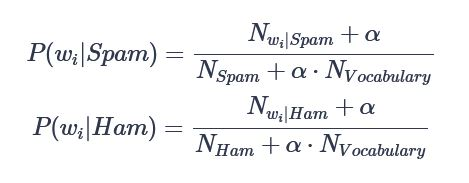

In these formulas:
* P(wi | spam): the (relative) probability of a word to appear, given this is a spam message
* P(wi | ham): the (relative) probability of a word to appear, given this is a not-spam message
* N-wi-spam: the number of times this word appears in all spam messages combined
* N-wi-ham: the number of times this word appears in all not-spam messages combined
* N-spam: total number of spam messages
* N-ham: total number of not-spam messages
* N-vocabulary: total number of words in the vocabulary
* alpha: constant to use for ['Laplace smoothing'](https://en.wikipedia.org/wiki/Additive_smoothing)

We'll go calculate all of this.
We start with the constants, then continue with the invididual words.


In [36]:
# First separate our training set into separate sets (spam and not-spam)
training_set_spam = training_set_wordcount[training_set_wordcount['label']=='spam']
training_set_notspam = training_set_wordcount[training_set_wordcount['label']=='ham']

In [37]:
# Calculate the chances something is spam, not-spam
p_spam = len(training_set_spam)/len(training_set_wordcount)
p_notspam = len(training_set_notspam)/len(training_set_wordcount)
print (p_spam, p_notspam)

0.1363840287124271 0.863615971287573


In [38]:
# Calculate number of words in spam messages, number of words in not-spam messages
n_spam = training_set_spam.sum(numeric_only=True).sum()
n_notspam = training_set_notspam.sum(numeric_only=True).sum()
print (n_spam, n_notspam, n_spam+n_notspam)

15473 56466 71939


In [39]:
# Calculate the number of words in the vocabulary
n_vocabulary = len(vocabulary)
print (n_vocabulary)

7803


In [40]:
# Initiate alpha for Laplace smoothing
alpha = 1

All the printed results above look good, in line with numbers that we saw earlier.

Now, let's calculate the proportional probabilities for all words in the vocubulary, P(wi | spam) and P(wi | not-spam), according to the formulas above.

Due to performance concerns, let's first do the calculations for one word that is likely to be used quite frequently ('msg'). This will also be helpful for verification purposes in a next step.

In [41]:
# Test for one word (msg) the calculation of conditional probabilities
testword = 'msg'
n_testword_spam = training_set_spam[testword].sum()
n_testword_notspam = training_set_notspam[testword].sum()
n_testwordtotal = training_set_wordcount[testword].sum()
print('Wordcounts (spam/not-spam/total):',n_testword_spam, n_testword_notspam, n_testwordtotal)
p_testword_spam = (n_testword_spam + alpha)/(n_spam + alpha*n_vocabulary)
p_testword_notspam = (n_testword_notspam + alpha)/(n_notspam + alpha*n_vocabulary)
print('Proportional probabilities (spam / not-spam):', p_testword_spam, p_testword_notspam)

Wordcounts (spam/not-spam/total): 45 37 82
Proportional probabilities (spam / not-spam): 0.001976284584980237 0.0005912648399695032


Looks reasonable. The word 'msg' appears a bit more in the spam messages, but given that the ratio between spam and not-spam messages (13 vs 87) its proportional probability is approximately one fourth of the other.

So let's apply this to all words, and store the results in two dictionaries. One dictionary for spam, one for not-spam. And both containing for all words in the vocabulary the proportional probabilities to be part of a message.

In [42]:
# Initiate empty dictionaries per word
p_spam_perword = {word: 0 for word in vocabulary}
p_notspam_perword = {word: 0 for word in vocabulary}

In [43]:
# For every word in the vocabulary, calculate the proportional probabilities and store in the respective dictionaries
for word in vocabulary:
    n_word_spam = training_set_spam[word].sum()
    n_word_notspam = training_set_notspam[word].sum()
    p_word_spam = (n_word_spam + alpha)/(n_spam + alpha*n_vocabulary)
    p_word_notspam = (n_word_notspam + alpha)/(n_notspam + alpha*n_vocabulary)
    p_spam_perword[word] = p_word_spam
    p_notspam_perword[word] = p_word_notspam   


In [44]:
# To verify the result, check for the word 'msg'
print ('Proportional spam probability for the word msg:', p_spam_perword['msg'])
print ('Proportional not-spam probability for the word msg:', p_notspam_perword['msg'])

Proportional spam probability for the word msg: 0.001976284584980237
Proportional not-spam probability for the word msg: 0.0005912648399695032


That's the same as what we saw above, looks good. 

Let's also show for a few more words:
* "u": used a lot, typically in private messages, so we would expect to have a higher probability for not-spam
* "john": a name, so we would typically expect it also mainly in private messages, higher probability for not-spam
* "prize": so that's a word that we could expect to be more frequent in spam messages

In [45]:
# Check for the word 'u'
testword = 'u'
print ('Proportional spam probability for the word', testword, 'is', p_spam_perword[testword])
print ('Proportional not-spam probability for the word u:', p_notspam_perword[testword])

# Check for 'john'
testword = 'john'
print ('Proportional spam probability for the word', testword, 'is', p_spam_perword[testword])
print ('Proportional not-spam probability for the word u:', p_notspam_perword[testword])

# Check for 'prize'
testword = 'prize'
print ('Proportional spam probability for the word', testword, 'is', p_spam_perword[testword])
print ('Proportional not-spam probability for the word u:', p_notspam_perword[testword])


Proportional spam probability for the word u is 0.006014779171678982
Proportional not-spam probability for the word u: 0.01252547884672237
Proportional spam probability for the word john is 4.296270836913559e-05
Proportional not-spam probability for the word u: 0.00021783441472560642
Proportional spam probability for the word prize is 0.0030503522942086267
Proportional not-spam probability for the word u: 1.555960105182903e-05


That all looks good.

## Create the spam classifier

In this step we're going to create the spam classifier. It will take a message as an input, and then calculate the proportional probabilities this message to be spam or not-spam, given its words. Then it classifies the message according to the highest of the two values.

These are the formulas for the probabilities:

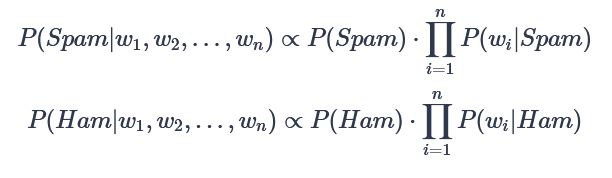

In these formulas:
* P(spam | w1, w2, ... wn): the proportional probability of a message to be spam, given its words
* P(ham | w1, w2, ... wn): the proportional probability of a message to be not-spam, given its words
* P(spam): the probability a message is spam in the first place
* P(not-spam): the probability a message is not-spam in the first place
* P(wi | spam): the proportional probability of a word appearing in spam (as calculated above); these are multiplied for all words in the message
* P(wi | ham): the proportional probability of a word appearing in not-spam (as calculated above); these are multiplied for all words in the message

We'll proceed with building a function that takes a message as its input and will return both proportional probabilities and a classification. Do note that:
* words in the message that are not in the vocabulary are ignored
* in case the calculated proportional probabilities are exactly the same, we'll classify as "too close to call"; we may need to refine this later


In [46]:
# Import re library to enable reformatting the message
import re

# Create function to classify a message. Returns two proportional probabilities, and an outcome

def classify(message):
    # In similar way as above for the training set, split the message into individual words
    message = re.sub(r'\W', ' ',message)
    message = message.lower()
    message = message.split()
    # print(message) - commented out after verification
    
    # Initiate the (proportional) probabilities. Use p_spam and p_notspam as they are the first term anyway.
    p_spam_given_message = p_spam
    p_notspam_given_message = p_notspam
    
    # Iterate over the words in the message. In case it is a known word, multiply with the respective proportional probabilities
    for word in message:
        if word in vocabulary:
            p_spam_given_message = p_spam_given_message * p_spam_perword[word]
            p_notspam_given_message = p_notspam_given_message * p_notspam_perword[word]
        # else: - commented out after verification
            #print('Did not find the word', word, 'and ignored it.')
    
    # Classify by comparing the proportional probabilities
    if p_spam_given_message < p_notspam_given_message:
        outcome = 'not spam'
    elif p_spam_given_message > p_notspam_given_message:
        outcome = 'spam'
    elif p_spam_given_message == p_notspam_given_message:
        outcome = 'too close to call'
    
    # Return 3 values
    return p_spam_given_message, p_notspam_given_message, outcome


Let's test this on two messages of which we would expect one to be spam, another one to be not-spam.

In [47]:
# Test on a message that looks like spam
test_message_1 = 'WINNER!! This is the secret code to unlock the money: C3421.'
print ('Message text:', test_message_1)
msg_p_spam, msg_p_notspam, msg_outcome = classify(test_message_1)
print('Proportional chance this message is spam:', msg_p_spam)
print('Proportional chance this message is not spam:', msg_p_notspam)
print('Classification:', msg_outcome)

print('\n')

# Test on a message that looks like not-spam
test_message_2 = 'Sounds good, Tom, then see u there'
print ('Message text:', test_message_2)
msg_p_spam, msg_p_notspam, msg_outcome = classify(test_message_2)
print('Proportional chance this message is spam:', msg_p_spam)
print('Proportional chance this message is not spam:', msg_p_notspam)
print('Classification:', msg_outcome)


Message text: WINNER!! This is the secret code to unlock the money: C3421.
Proportional chance this message is spam: 1.5368193350514874e-25
Proportional chance this message is not spam: 2.8048436891668135e-27
Classification: spam


Message text: Sounds good, Tom, then see u there
Proportional chance this message is spam: 4.506566007230723e-25
Proportional chance this message is not spam: 2.065815212502894e-21
Classification: not spam


Both correct, that looks promising! Let's also try it out on one message of the test set already.

In [48]:
# Test on a message from the test set
print('Message text:', test_set.iloc[0]['SMS'])
print('Message was classified by a human as:', test_set.iloc[0]['label'])
print('Output of our spam classifier:', classify(test_set.iloc[0]['SMS']))

Message text: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Message was classified by a human as: ham
Output of our spam classifier: (7.525433835951265e-68, 1.5906955434184212e-59, 'not spam')


That looks good too!

## Test the spam classifier

Now we can put our spam classifier to a real test. Earlier on we separated out a "test set" with 1114 messages. For all of them we do know how a human classified it. Our algorithm hasn't seen them before though, and we're going to ask it to classify all of them. Then we can compare with the human classification, and (assuming the human classification is correct) assess how well our spam classifier performs.

We'll update our test set dataframe with 3 columns, and fill those with the results of the spam classifier.

In [49]:
# Add the 3 columns with an initial value
test_set['p_spam']=0
test_set['p_notspam']=0
test_set['classification']='to do'
test_set.head(3)

,label,SMS,p_spam,p_notspam,classification
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0,0,to do
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,0,0,to do
21,ham,I‘m going to try for 2 months ha ha only joking,0,0,to do


In [50]:
# Fill the columns by applying the our classification function to every row
test_set['p_spam'] = test_set['SMS'].apply(lambda SMS: classify(SMS)[0])
test_set['p_notspam'] = test_set['SMS'].apply(lambda SMS: classify(SMS)[1])
test_set['classification'] = test_set['SMS'].apply(lambda SMS: classify(SMS)[2])

# Show a summary of the classification results
test_set['classification'].value_counts()

not spam             979
spam                 134
too close to call    1  
Name: classification, dtype: int64

Values look reasonably in line with expectation, with many more not-spam as spam in a ratio similar to human classification. Only for one message apparently both proportional probabilities were exactly the same.

In [51]:
# Show a sample of the result
test_set.head(10)

,label,SMS,p_spam,p_notspam,classification
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",7.525434e-68,1.590696e-59,not spam
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,1.810913e-92,2.015411e-90,not spam
21,ham,I‘m going to try for 2 months ha ha only joking,7.244634e-40,3.995048e-35,not spam
24,ham,Ffffffffff. Alright no way I can meet up with you sooner?,6.352126e-34,3.470980e-27,not spam
25,ham,Just forced myself to eat a slice. I'm really not hungry tho. This sucks. Mark is getting worried. He knows I'm sick when I turn down pizza. Lol,1.186144e-100,8.872769e-83,not spam
28,ham,"I'm back &amp; we're packing the car now, I'll let you know if there's room",1.582828e-57,8.778320e-45,not spam
35,ham,Yup... Ok i go home look at the timings then i msg ü again... Xuhui going to learn on 2nd may too but her lesson is at 8am,3.671964e-93,2.489850e-76,not spam
56,spam,"Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out!",2.498004e-92,1.653953e-103,spam
60,ham,Your gonna have to pick up a $1 burger for yourself on your way home. I can't even move. Pain is killing me.,1.249651e-71,4.107227e-62,not spam
62,ham,Its a part of checking IQ,1.220869e-21,3.842405e-19,not spam


Awesome! 10 out of 10 correct for this first sample. 

Let's explore more. What we will do is add a column 'correctness' to the dataframe to indicate whether the spam classifier got the same result as human classification did. Then we can easily calculate statistics, and look at examples where we don't get the right result.

In [52]:
# Define function to assess correctness of the spam classifier for a message
def correctness(row):
    # Initialize output as 'not set'
    output = 'not set'
    # Set output for spam messages
    if row['label'] == 'spam':
        if row['classification'] == 'spam':
            output = 'correct' 
        if row['classification'] == 'not spam':
            output = 'incorrect' 
    # Set output for not-spam messages
    if row['label'] == 'ham':
        if row['classification'] == 'not spam':
            output = 'correct'
        if row['classification'] == 'spam':
            output = 'incorrect'
    return output        

In [53]:
# Test on the first row
correctness(test_set.iloc[0])

'correct'

In [54]:
# Initialize new column in the test set dataframe
test_set['correctness'] = 'to do'

# Apply function to every row
test_set['correctness'] = test_set.apply(correctness, axis = 1)

In [55]:
# Show the result (sample)
test_set.head(10)

,label,SMS,p_spam,p_notspam,classification,correctness
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",7.525434e-68,1.590696e-59,not spam,correct
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,1.810913e-92,2.015411e-90,not spam,correct
21,ham,I‘m going to try for 2 months ha ha only joking,7.244634e-40,3.995048e-35,not spam,correct
24,ham,Ffffffffff. Alright no way I can meet up with you sooner?,6.352126e-34,3.470980e-27,not spam,correct
25,ham,Just forced myself to eat a slice. I'm really not hungry tho. This sucks. Mark is getting worried. He knows I'm sick when I turn down pizza. Lol,1.186144e-100,8.872769e-83,not spam,correct
28,ham,"I'm back &amp; we're packing the car now, I'll let you know if there's room",1.582828e-57,8.778320e-45,not spam,correct
35,ham,Yup... Ok i go home look at the timings then i msg ü again... Xuhui going to learn on 2nd may too but her lesson is at 8am,3.671964e-93,2.489850e-76,not spam,correct
56,spam,"Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out!",2.498004e-92,1.653953e-103,spam,correct
60,ham,Your gonna have to pick up a $1 burger for yourself on your way home. I can't even move. Pain is killing me.,1.249651e-71,4.107227e-62,not spam,correct
62,ham,Its a part of checking IQ,1.220869e-21,3.842405e-19,not spam,correct


Let's have a first look at our statistics.

In [56]:
# Check value-counts for correctness
test_set['correctness'].value_counts()

correct      1100
incorrect    13  
not set      1   
Name: correctness, dtype: int64

That seems to work very, very well! We'll calculate more statistics later. Let's now first take a look at the messages where the result was not correct.

In [57]:
# Show incorrectly classified messages (and the message where correctness was not set)
incorrectly_classified = test_set[test_set['correctness']!='correct'].sort_values(['label', 'classification'])
incorrectly_classified

,label,SMS,p_spam,p_notspam,classification,correctness
216,ham,Finally the match heading towards draw as your prediction.,6.340296e-24,5.622059e-24,spam,incorrect
2173,ham,Yavnt tried yet and never played original either,1.114261e-26,6.025706e-27,spam,incorrect
4600,ham,Have you laid your airtel line to rest?,7.121424e-25,7.669993e-26,spam,incorrect
4703,ham,Anytime...,5.859427e-05,4.031256e-05,spam,incorrect
1863,ham,"The last thing i ever wanted to do was hurt you. And i didn't think it would have. You'd laugh, be embarassed, delete the tag and keep going. But as far as i knew, it wasn't even up. The fact that you even felt like i would do it to hurt you shows you really don't know me at all. It was messy wednesday, but it wasn't bad. The problem i have with it is you HAVE the time to clean it, but you choose not to. You skype, you take pictures, you sleep, you want to go out. I don't mind a few things here and there, but when you don't make the bed, when you throw laundry on top of it, when i can't have a friend in the house because i'm embarassed that there's underwear and bras strewn on the bed, pillows on the floor, that's something else. You used to be good about at least making the bed.",0.000000e+00,0.000000e+00,too close to call,not set
869,spam,Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r,4.868851e-71,2.972185e-61,not spam,incorrect
1469,spam,Hi its LUCY Hubby at meetins all day Fri & I will B alone at hotel U fancy cumin over? Pls leave msg 2day 09099726395 Lucy x Calls£1/minMobsmoreLKPOBOX177HP51FL,4.452791e-81,2.015650e-76,not spam,incorrect
1638,spam,"0A$NETWORKS allow companies to bill for SMS, so they are responsible for their ""suppliers"", just as a shop has to give a guarantee on what they sell. B. G.",4.567450e-77,1.379336e-73,not spam,incorrect
2965,spam,"Do you ever notice that when you're driving, anyone going slower than you is an idiot and everyone driving faster than you is a maniac?",2.386440e-80,3.235119e-68,not spam,incorrect
3419,spam,LIFE has never been this much fun and great until you came in. You made it truly special for me. I won't forget you! enjoy @ one gbp/sms,4.119620e-94,1.578211e-83,not spam,incorrect


Interesting to see the examples. It would take quite some analysis to figure out what exactly causes these to be not correct, and even more effort to figure out if there would be anything to do about it. An initial thought could be that possibly these ones were 'close' in a sense that both conditional probabilities are similar, however looking at the numbers that does not seem to be the case for most. (E.g. `e-71` and `e-61` imply that one is in the range of 10,000,000,000 as high as the other!)

The one where correctness was not set is obviously the one that was too close to call. Both probabilities appear to be 0 for this one. Maybe the message is so long that the multiplication of many small numbers went into a range beyond this computer's ability to handle? Not exploring this further though; it's only one out of more than a thousand messages.  

Rather, let's calculate statistics for the accuracy of our spam classifier!

In [58]:
# Count total, spam, and not-spam messages
count_test_set = len(test_set)
count_spam = len(test_set[test_set['label']=='spam'])
count_notspam = len(test_set[test_set['label']=='ham'])
# print(count_test_set, count_spam, count_notspam, count_spam+count_notspam) - commented out after verifying

# Count correctly classified spam and not-spam messages
count_spam_correct = len(test_set[(test_set['label']=='spam') & (test_set['classification']=='spam')])
count_notspam_correct = len(test_set[(test_set['label']=='ham') & (test_set['classification']=='not spam')])
count_correct = count_spam_correct + count_notspam_correct
# print(count_spam_correct, count_notspam_correct) - commented out after verifying

# Calculate accuracies
accuracy_overall = count_correct / count_test_set
accuracy_spam = count_spam_correct / count_spam
accuracy_notspam = count_notspam_correct / count_notspam

print('Overall accuracy is {:.2%}'.format(accuracy_overall))
print('Accuracy for spam messages {:.2%}'.format(accuracy_spam))
print('Accuracy to not-spam messages is {:.2%}'.format(accuracy_notspam))

Overall accuracy is 98.74%
Accuracy for spam messages 93.53%
Accuracy to not-spam messages is 99.49%


So overall, almost 99% of the messages in the test set were classified correctly by our spam classifier.

For messages that were spam (that is: a human classified them as such) the accuracy was somewhat lower. So suppose that you would apply this classifier as a filter, spam messages would still have a chance of some 6.5% to get through.

On the other side, the chance that a not-spam message would be blocked because the spam classifier classified it as spam is only around 0.5%.

## Conclusion and next steps

In this project, we took a dataset of around 5000 SMS messages and split it into a training set (80%) and a test set (20%). Using the individual words in the messages (of the training set) and applying Naive Bayes, we built a spam classifier that was able to classify almost 99% of the messages in the test set correctly as "spam" or "not spam". Although I hadn't explicitly expressed a goal or expectation, personally I am amazed by this result!

It is not easy to identify next steps, given the accuracy is so high already. One may try to figure out under which circumstances the classification goes wrong, or has a significant chance to go wrong. And then classify these messages as 'too close to call' and/or 'human judgment required'. This may prove hard though.

Another direction could be to look at more advanced algorithms. A potential weakness of Naive Bayes is that it assumes independece of all probabilities (that is why it is called 'naive'). In this case assuming that the probability of a word to be part of a message is unrelated to that of another word to be part of the same message. In reality, it is very likely that particular combinations of words are common, and that taking that into account could yield better results. Not having studied this though (doing that would be the first step), I expect this to be far from straightforward.

For now, I am happy with the result though, and conclude this study!